# Preparation

In [1]:
import sys

sys.path.append("..")

from updpc import *

## Imaging parameters

In [2]:
# Illumination parameters, see cosSourceGen() in updpc_algorithm.py
na_in = 0.330   # NA of inside disk in illumination
w_in = 0.073    # Half width of rectangles in illumination
na_cos = 1.435  # Length scale of the cosine in illumination
na_ill = 1.33   # NA of illumination

In [3]:
wavelength = 0.660  # in micron
mag, na = 1000 / 3, 1.4 # Magnification, NA of objective

pixel_size_cam = 3.45 * 2  # pixel size of camera in micron
pixel_size = pixel_size_cam / mag  # in micron

source_pols = [[90, -45], [45, 0]]
a0 = 1

# Phase Retrieval

## Path

In [4]:
raw_dir = "../data/raw" # Directory containing raw images
phase_dir = "../data/phase" # Directory to save phase images
tif_paths = list_tifs(raw_dir)
print_list(tif_paths)

0 ../data/raw\background_2023-11-28T15-51-28.081_0_frame1-10.tif
1 ../data/raw\background_2023-11-28T15-52-12.514_0_frame1-10.tif
2 ../data/raw\background_2023-11-28T15-52-58.04_0_frame1-10.tif
3 ../data/raw\long2_4_2023-11-28T15-49-06.145337_170.tif
4 ../data/raw\long2_4_2023-11-28T15-49-06.145337_171.tif
5 ../data/raw\long2_4_2023-11-28T15-49-06.145337_172.tif
6 ../data/raw\long2_4_2023-11-28T15-49-06.145337_173.tif
7 ../data/raw\long2_4_2023-11-28T15-49-06.145337_174.tif


## Background

Background images are assumed to be in `raw_dir`.

Total number of elements: 50135040
Number of outliers: 0
Outlier rate: 0.0 %
Total number of elements: 50135040
Number of outliers: 0
Outlier rate: 0.0 %
Total number of elements: 50135040
Number of outliers: 0
Outlier rate: 0.0 %


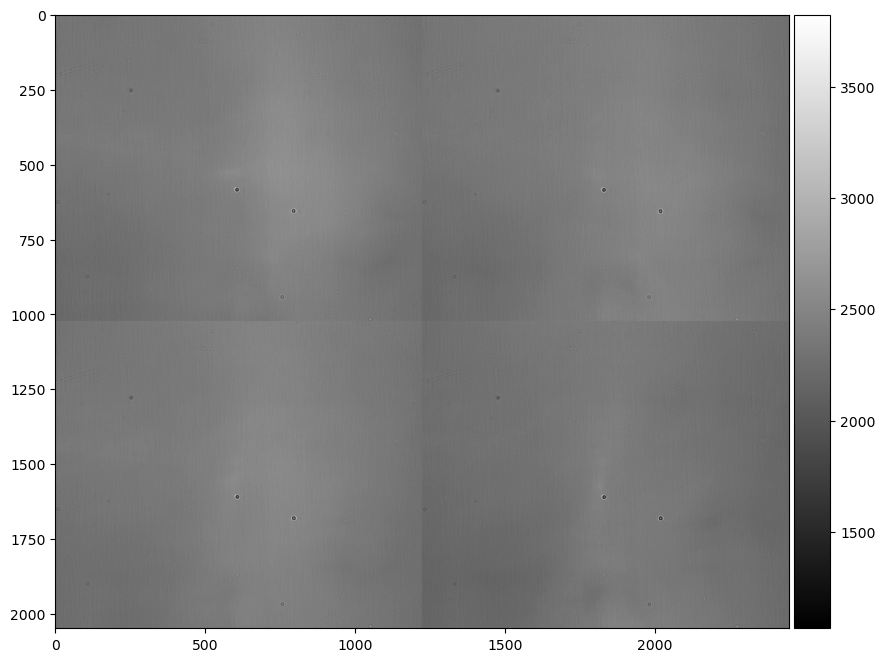

In [5]:
bg_path = join(raw_dir, "background.tif")
if exists(bg_path):
    bg = imread(bg_path)
    imshow(bg)
else:
    bg_paths = filter_str_list(tif_paths, include="background")
    bg = np.median([mean_without_outliers(imread(bg_path)) for bg_path in bg_paths], axis=0)
    imshow(bg)
    imwrite_f32(bg_path, bg)

## Camera parameter

In [6]:
camera_dark_noise = imread("../data/calibration_result/intercept_intensity_exposure.tif")
I0 = quad_to_raw(imread(bg_path))

## Decide the regularization parameters

In [7]:
tif_paths = filter_str_list(tif_paths, exclude="background")
print_list(tif_paths)

0 ../data/raw\long2_4_2023-11-28T15-49-06.145337_170.tif
1 ../data/raw\long2_4_2023-11-28T15-49-06.145337_171.tif
2 ../data/raw\long2_4_2023-11-28T15-49-06.145337_172.tif
3 ../data/raw\long2_4_2023-11-28T15-49-06.145337_173.tif
4 ../data/raw\long2_4_2023-11-28T15-49-06.145337_174.tif


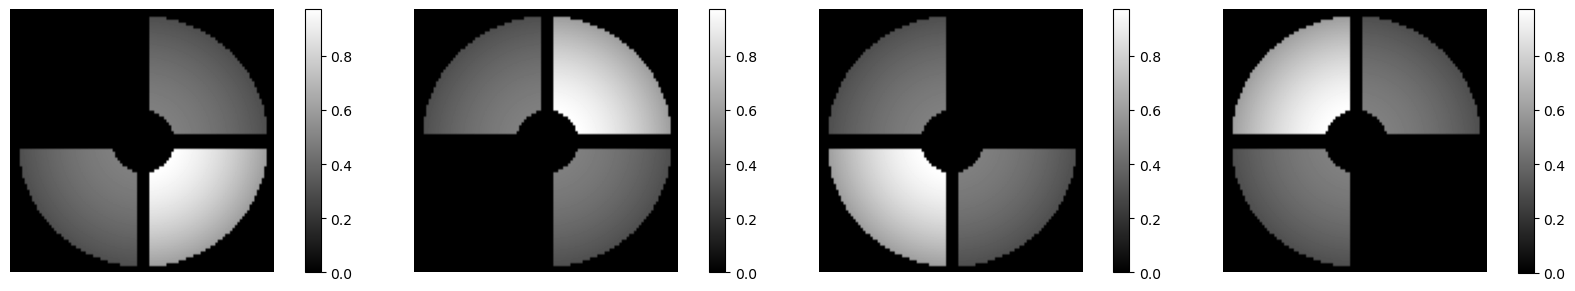

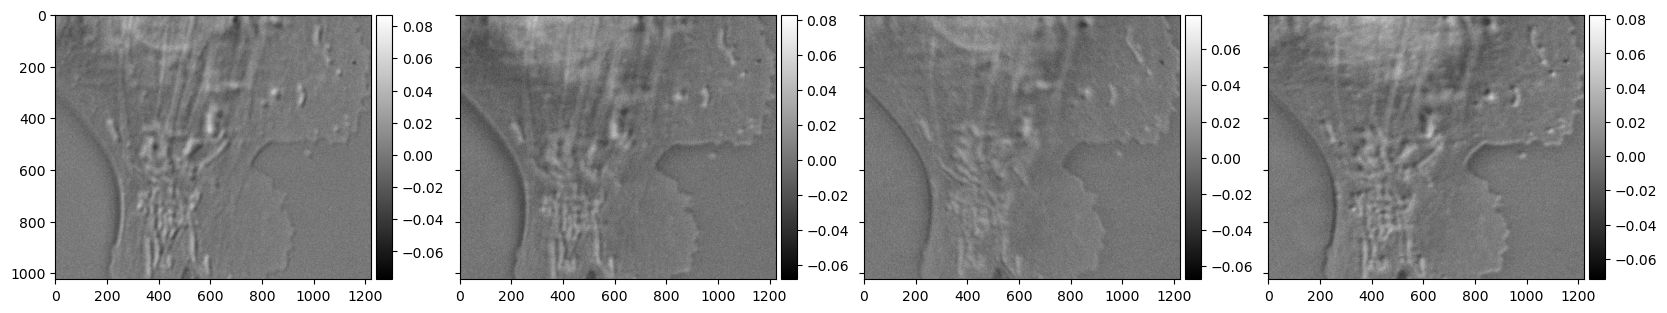

In [8]:
tif_path = tif_paths[0]
raw_image = imread(tif_path)

corrected_raw_image = (raw_image - camera_dark_noise) / I0
corrected_images = raw_to_quadarray(corrected_raw_image)

solver = UpDPCSolver(corrected_images, wavelength, na, na_in, pixel_size, source_pols, na_ill, na_cos, w_in)
solver.plot_source()
solver.plot_images()

Regularization parameter: 1e-06 1e-06


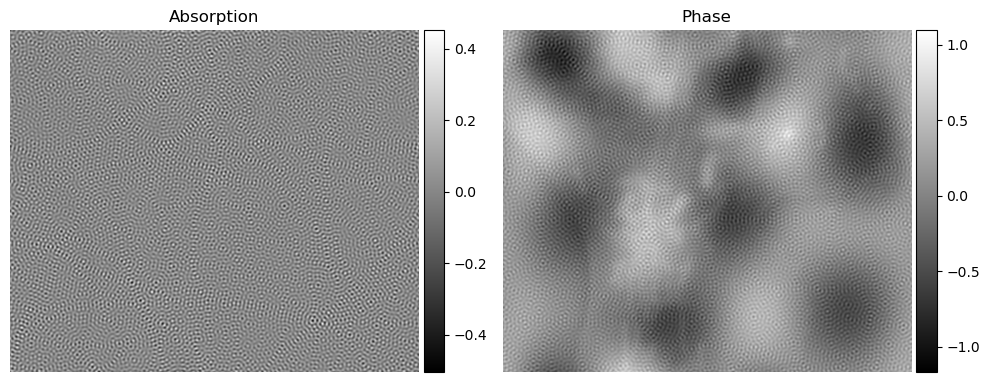

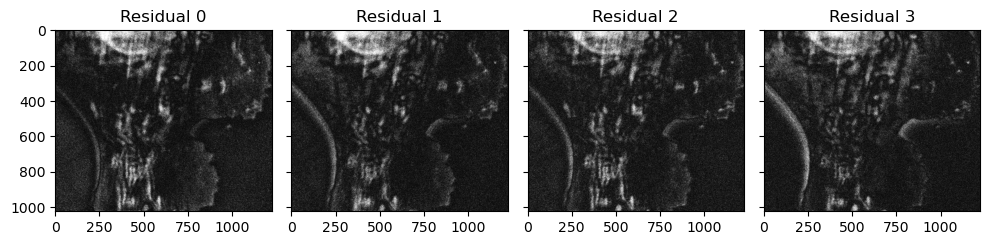

Regularization parameter: 1e-05 1e-05


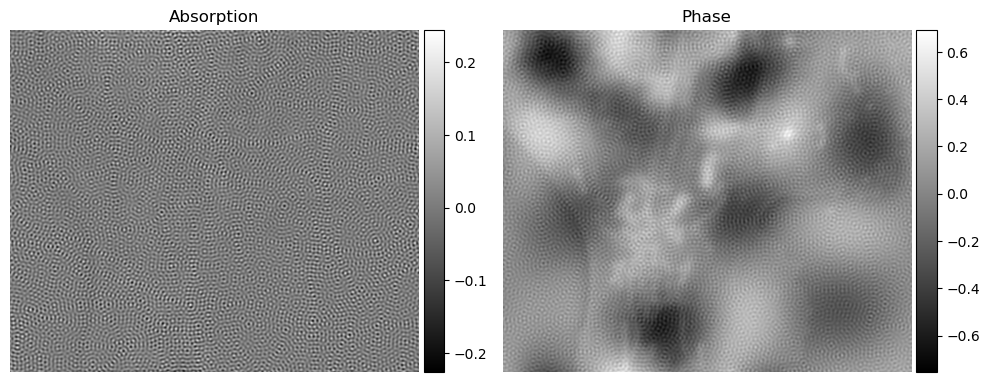

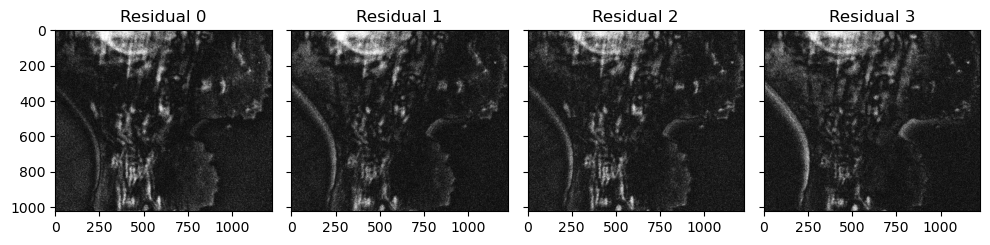

Regularization parameter: 0.0001 0.0001


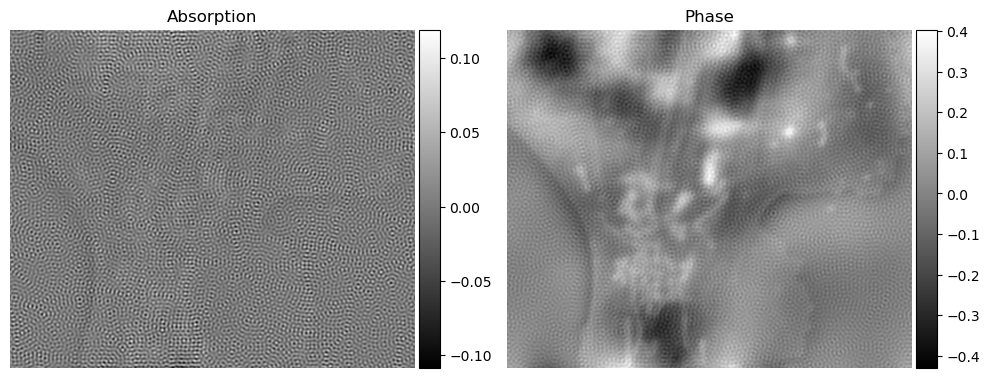

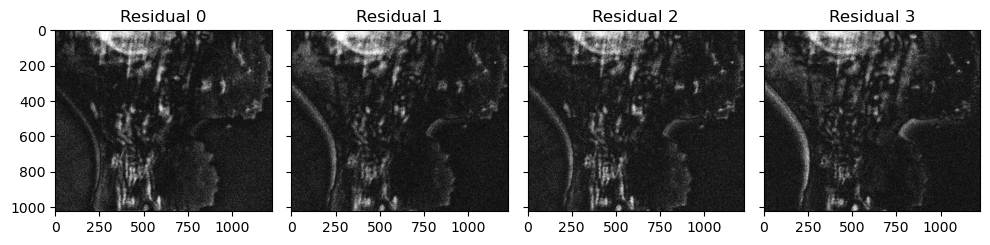

Regularization parameter: 0.001 0.001


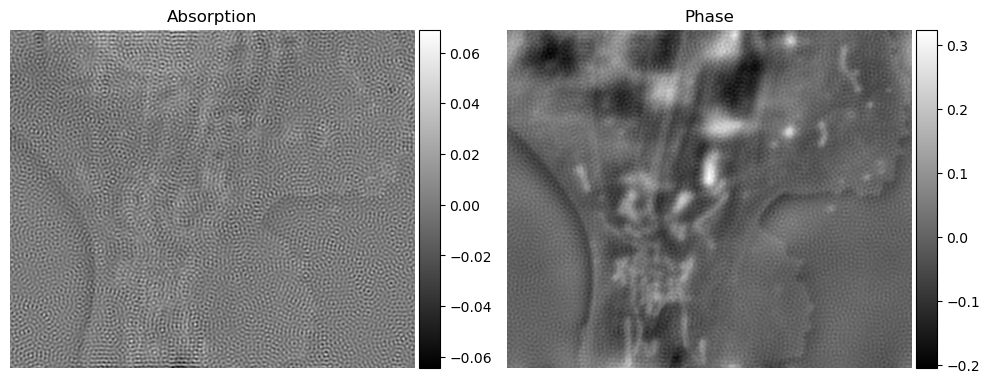

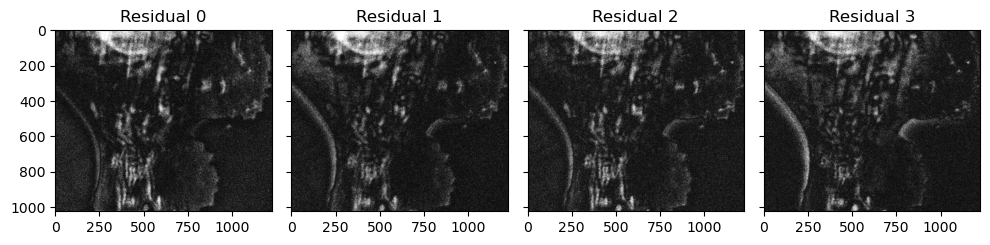

Regularization parameter: 0.01 0.01


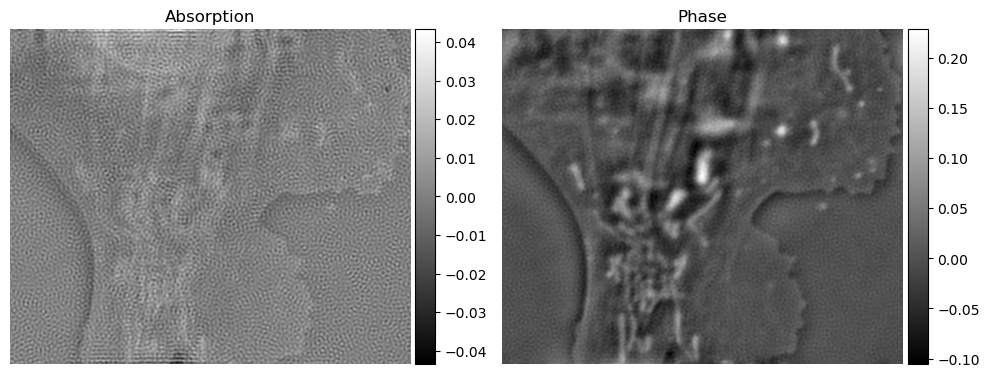

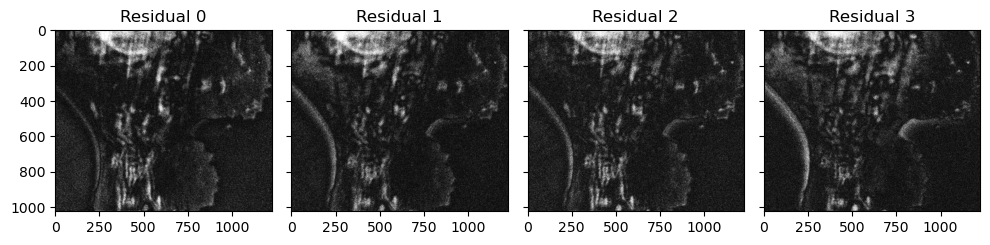

Regularization parameter: 0.1 0.1


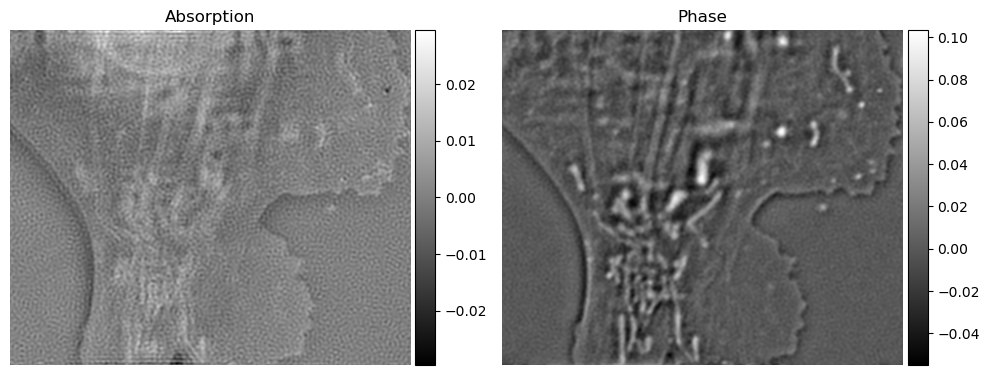

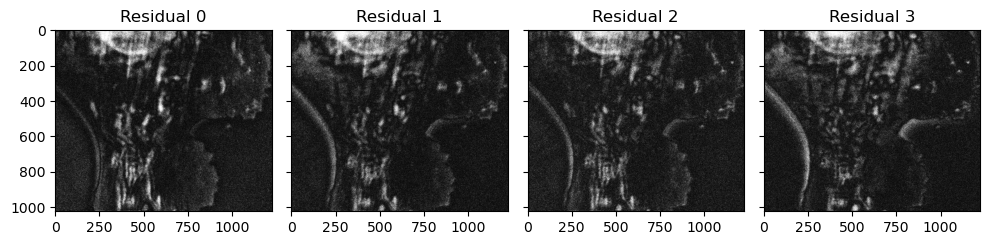

Regularization parameter: 1 1


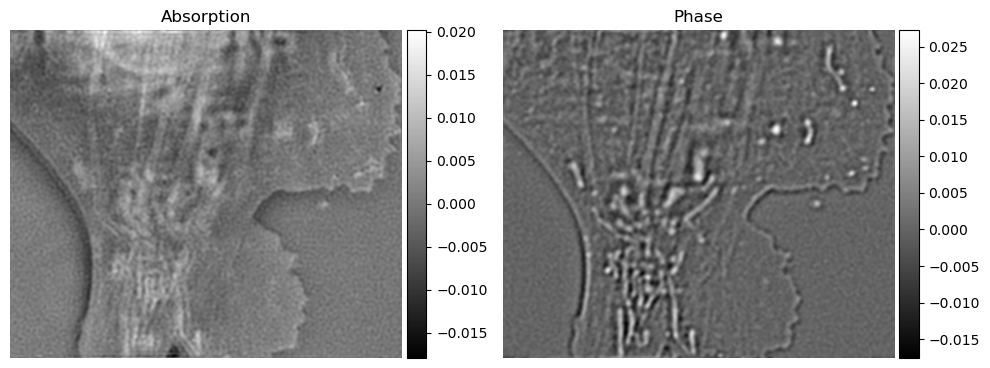

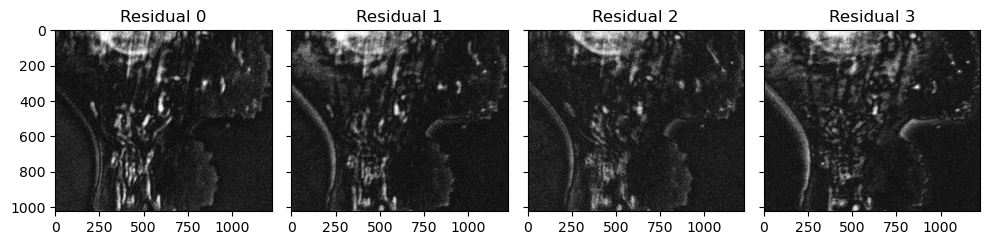

Regularization parameter: 10 10


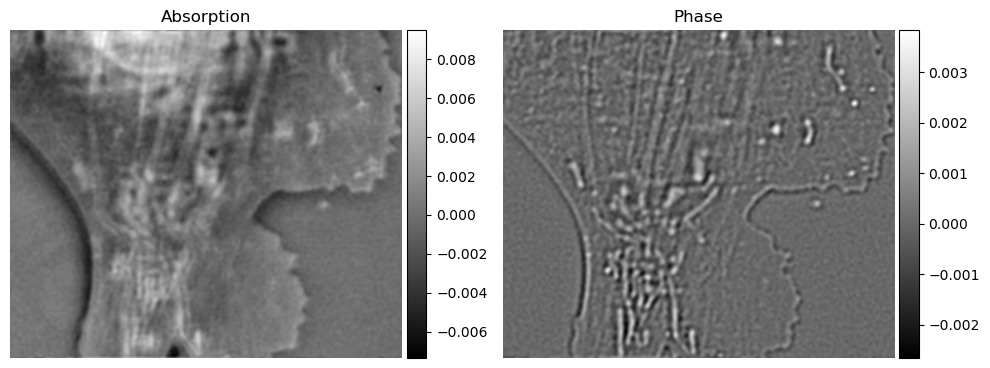

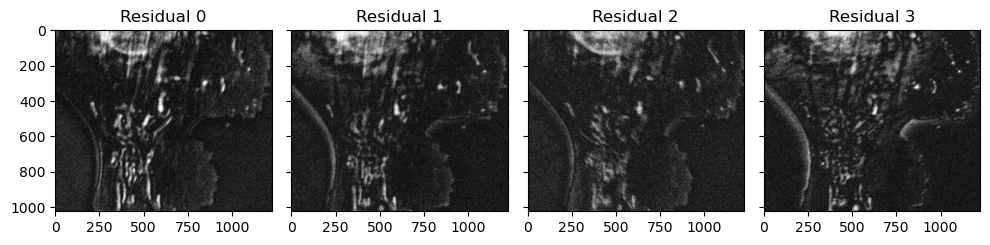

In [9]:
filename = basename_noext(tif_path)
folder_base = f"UpDPC_NAill{na_ill}_NArect{w_in}_NAcos{na_cos}_test"
residuals = []
regs = []
Fphases = []
reg_num = 8
log10_reg_min = -6
log10_reg_ratio = 1
log10_reg_diff = 0

out_dir = join(phase_dir, folder_base)
makedirs(out_dir, exist_ok=True)

for log_reg in range(reg_num):
    reg_p = pow(10, log_reg * log10_reg_ratio + log10_reg_min)
    reg_u = pow(10, log_reg * log10_reg_ratio + log10_reg_min + log10_reg_diff)
    print("Regularization parameter:", reg_u, reg_p)
    solver.setRegularizationParameters(reg_u=reg_u, reg_p=reg_p)
    result = solver.solve()[0]
    absorption = result.real
    phase = result.imag
    residual = (solver.I_from_phase_abs_wogrid(phase, absorption) - corrected_images) ** 2
    residuals.append(residual.mean())
    regs.append(reg_p)

    # np.save(npy_path, np.array(residuals))
    out_path = join(out_dir, filename + f"_{reg_u}_absorption.tif")
    imwrite(out_path, absorption.astype(np.float32), imagej=True)
    out_path = join(out_dir, filename + f"_{reg_p}_phase.tif")
    imwrite(out_path, phase.astype(np.float32), imagej=True)
    Fphases.append((np.abs(F(phase)) ** 2).mean())

    # plot
    _, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

    divider = make_axes_locatable(axes[0])
    cax_1 = divider.append_axes("right", size="5%", pad=0.05)
    plot = axes[0].imshow(absorption, cmap="gray", extent=[0, result.shape[-1], 0, result.shape[-2]])
    axes[0].axis("off")
    plt.colorbar(plot, cax=cax_1)
    # plt.colorbar(plot, cax=cax_1, ticks=[-0.15, 0.02])
    axes[0].set_title("Absorption")

    divider = make_axes_locatable(axes[1])
    cax_2 = divider.append_axes("right", size="5%", pad=0.05)
    plot = axes[1].imshow(phase, cmap="gray", extent=[0, result.shape[-1], 0, result.shape[-2]])
    axes[1].axis("off")
    plt.colorbar(plot, cax=cax_2)
    # plt.colorbar(plot, cax=cax_2, ticks=[-1.0, 3.0])
    axes[1].set_title("Phase")
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)
    for i, ax in enumerate(axes):
        ax.imshow(auto_contrast(residual[i]), cmap="gray")
        ax.set_title(f"Residual {i}")
    plt.tight_layout()
    plt.show()

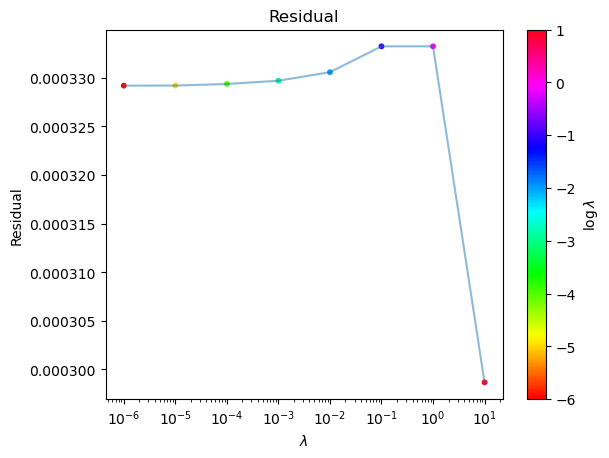

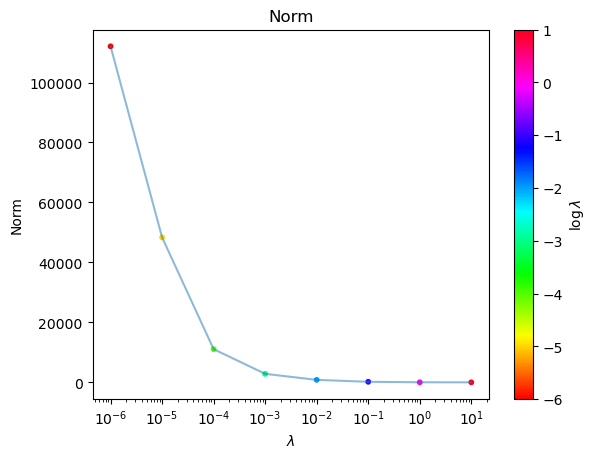

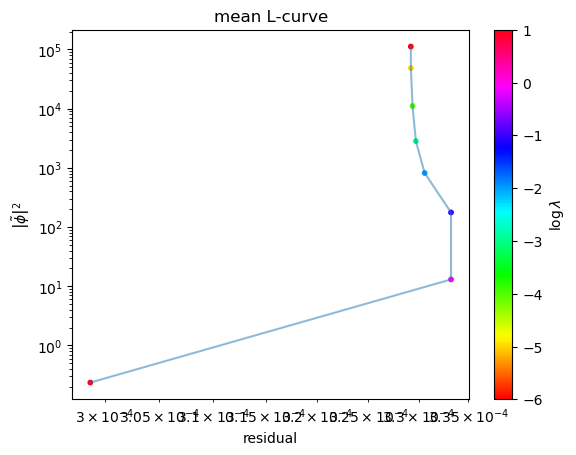

In [10]:
residuals = np.array(residuals)
residuals.shape

res_mean = residuals[:]
plt.plot(regs, res_mean, alpha=0.5)
plt.scatter(regs, res_mean, c=np.log10(regs), s=10, cmap="hsv")
plt.colorbar(label=r"$\log{\lambda}$")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"Residual")
plt.xscale("log")
plt.title("Residual")
plt.show()

plt.plot(regs, Fphases, alpha=0.5)
plt.scatter(regs, Fphases, c=np.log10(regs), s=10, cmap="hsv")
plt.colorbar(label=r"$\log{\lambda}$")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"Norm")
plt.xscale("log")
plt.title("Norm")
plt.show()

plt.plot(res_mean, Fphases, alpha=0.5)
plt.scatter(res_mean, Fphases, c=np.log10(regs), s=10, cmap="hsv")
plt.xlabel(r"residual")
plt.ylabel(r"$\left|\tilde{\phi}\right|^2$")
plt.colorbar(label=r"$\log{\lambda}$")
plt.xscale("log")
plt.yscale("log")
plt.title("mean L-curve")
plt.show()

## Compute all images in a folder

Assuming the same experimental condition.

In [11]:
from tqdm.notebook import tqdm

In [12]:
reg_p = 1e-1
reg_u = 1e-1 # does not matter

folder_base = f"UpDPC_NAill{na_ill}_NArect{w_in}_NAcos{na_cos}"
out_dir = join(phase_dir, folder_base)
makedirs(out_dir, exist_ok=True)

In [13]:
def save_phase(tif_path, reg_p, not_overwrite=True):
    filename = basename_noext(tif_path)
    out_path = join(out_dir, filename + f"_{reg_p}_phase.tif")
    solver.setRegularizationParameters(reg_u=reg_u, reg_p=reg_p)
    if exists(out_path) and not_overwrite:
        print(out_path, "skip")
        return out_dir
    print(out_path, "Start")
    dpc_raw_shape = get_tiff_shape(tif_path)
    if len(dpc_raw_shape) != 2:
        print(tif_path, f"is {len(dpc_raw_shape)}-dim image.")
        return -1
    if dpc_raw_shape[0] < camera_dark_noise.shape[0]:
        print("Shape", dpc_raw_shape, "is different from BG.")
        return -1
    dpc_raw = imread(tif_path)
    dpc_raw = (dpc_raw - camera_dark_noise) / I0
    dpc_images = raw_to_quadarray(dpc_raw)
    phase = solver.solve(dpc_imgs=dpc_images)[0].imag
    imwrite(out_path, np.array(phase, dtype=np.float32), imagej=True)

In [14]:
for tif_path in tqdm(
    filter_str_list(
        tif_paths,
        exclude=[
            "background",
        ],
    )[:]
):
    save_phase(
        tif_path,
        reg_p,
        not_overwrite=False
    )

  0%|          | 0/5 [00:00<?, ?it/s]

../data/phase\UpDPC_NAill1.33_NArect0.073_NAcos1.435\long2_4_2023-11-28T15-49-06.145337_170_0.1_phase.tif Start
../data/phase\UpDPC_NAill1.33_NArect0.073_NAcos1.435\long2_4_2023-11-28T15-49-06.145337_171_0.1_phase.tif Start
../data/phase\UpDPC_NAill1.33_NArect0.073_NAcos1.435\long2_4_2023-11-28T15-49-06.145337_172_0.1_phase.tif Start
../data/phase\UpDPC_NAill1.33_NArect0.073_NAcos1.435\long2_4_2023-11-28T15-49-06.145337_173_0.1_phase.tif Start
../data/phase\UpDPC_NAill1.33_NArect0.073_NAcos1.435\long2_4_2023-11-28T15-49-06.145337_174_0.1_phase.tif Start


# EOF